We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add LAVD folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/LAVD2D")

# Overview

In the following notebook we evaluate the Lagrangian Averaged Vorticity Deviation (LAVD) on a 2-D homogeneous, isotropic turbulence. The notebook is structured as follows:

1. Import velocity data stored in the folder 'data/Turbulence'. Make sure that all the necessary files are stored in the folder 'data/Turbulence'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. Lagrangian Averaged Vorticity Deviation (LAVD):

    * Compute trajectories launched from a regular meshgrid.
    <br />
    
    * Compute the vorticity along particle trajectories 
    <br />
    \begin{equation}
    \mathbf{\omega}(\mathbf{x},t) = \nabla \times \mathbf{v}(\mathbf{x},t) 
    \end{equation}
    <br />
    * Compute LAVD as:
    <br />
    \begin{equation}
    \mathrm{LAVD}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{1}{t_N-t_0} \int_{t_0}^{t_N}| \omega(\mathbf{F}_{t_0}^{t}(\mathbf{x}_0)) - \overline{\omega}(t) |dt,
    \end{equation} where $ \overline{\mathbf{\omega}(t)} $ is the spatially averaged vorticity. <br />
 <br />
 
6. Extract vortex boundaries from LAVD using the algorithm proposed in [1]

 <br />
7. References

# Import data

In [ ]:
# import scipy
import scipy.io

# import numpy
import numpy as np

# load velocity data
turb_u = parent_directory + r'/data/Turbulence/turb_u'
      
# iterate over all files in folder 'turb_u' and load velocity data
i = 0
U = np.zeros((1024, 1024, 251))
V = np.zeros((1024, 1024, 251))
for filename in sorted(os.listdir(turb_u)):
    if filename.endswith(".mat"):
        file_u = os.path.join(turb_u, filename)
        mat_turb_u = scipy.io.loadmat(file_u)
        U[:,:,i] = mat_turb_u['u1']
        V[:,:,i] = mat_turb_u['u2']
        i+=1

# load x/y grid
X = scipy.io.loadmat(parent_directory + r'/data/Turbulence/grid.mat')['x']
Y = X.copy().transpose()

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# Number of cores for parallel computing
Ncores = 16

# time-interval over which data is defined
time_data = np.linspace(0, 25, 251, endpoint = True).reshape(1, -1)

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Initial time
t0 = 0 # float

# Final time
tN = 20 # float

# Time step-size
dt = 0.1 # float

# NOTE: For computing the backward trajectories set: tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval
lenT = abs(tN-t0) # float

# resolution
Nx = 400
Ny = 400

# set x-limits
xmin = 3
xmax = 5

# set x-limits
ymin = 1
ymax = 3

# specify domain over which to compute LCS
x_domain = np.linspace(xmin, xmax, Nx)
y_domain = np.linspace(ymin, ymax, Ny)

# make sure that domain is part of the data domain.
assert np.min(X) <= xmin <= np.max(X), " xmin must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(X) <= xmax <= np.max(X), " xmax must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(Y) <= ymin <= np.max(Y), " ymin must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(Y) <= ymax <= np.max(Y), " ymax must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(time_data) <= t0 <= np.max(time_data), " t0 must be between "+f'{np.min(time_data)} and {np.max(time_data)}'
assert np.min(time_data) <= tN <= np.max(time_data), " tN must be between "+f'{np.min(time_data)} and {np.max(time_data)}'

# grid-spacing
dx = x_domain[1]-x_domain[0]
dy = y_domain[1]-y_domain[0]

#compute meshgrid
X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # float between [1/100, 1/5]
aux_grid = [aux_grid_ratio*dx, aux_grid_ratio*dy] # list (2, )

# Interpolate velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default is "cubic". 

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline-object

# Lagrangian Averaged Vorticity Deviation (LAVD)

In [6]:
# Import function to compute trajectories/velocity along trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import function to compute gradient of velocity
from ipynb.fs.defs.gradient_velocity import gradient_velocity

# Import function to compute LAVD
from ipynb.fs.defs.LAVD import _LAVD

# Import function to check particle location
from ipynb.fs.defs.check_location import check_location

# Import package for parallel computing
from joblib import Parallel, delayed

# Split x0, y0 into N (equal) batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def parallel_Omega(x0_batch, y0_batch):
    
    # Define array containing vorticity along a trajectory
    omega = np.zeros((X_domain.shape[0]*X_domain.shape[1], len(time))) # array (Ny*Nx, Nt)
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch]) # array (2, Nx*Ny)
    
    # Compute trajectories
    Fmap = integration_dFdt(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data)[0] # array (Nt, 2, Nx*Ny)
    
    # Check if initial position is inside out outside flow domain.
    for i in range(Fmap.shape[2]):
        
        if check_location(X, Y, defined_domain, np.array([Fmap[0,0,i], Fmap[0,1,i]]))[0] != "IN": # bool
            
            Fmap[:,:,i] = np.nan
    
    omega = np.zeros((Fmap.shape[0], Fmap.shape[2])) # array (Nt, Ny*Nx)
    
    # Iterate over time
    for t in range(Fmap.shape[0]):
        
        # Compute gradient of velocity field
        grad_vel = gradient_velocity(time[t], Fmap[t,:,:], X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, delta, aux_grid) # (2,2,Nx*Ny)
    
        # Compute spin tensor
        W = .5*(grad_vel-grad_vel.transpose(1,0,2))  # array (2, 2, Ny*Nx)
                
        omega[t,:] = 2*W[0,1,:]

        return omega

In [7]:
# Vectorize initial conditions
x0 = X_domain.ravel() # array (Ny*Nx, )
y0 = Y_domain.ravel() # array (Ny*Nx, )

x0_batch = list(split(x0, Ncores)) # array (Ny*Nx, )
y0_batch = list(split(y0, Ncores)) # array (Ny*Nx, )

# compute parallel results
results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_Omega)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# Extract Omega from results of parallel computing
Omega = results[0]

for res in results[1:]:
    Omega = np.append(Omega, res, axis = 1)

# Reshape array from vectorized form to structured meshgrid
Omega = Omega.reshape((Omega.shape[0], X_domain.shape[0], X_domain.shape[1])) # array (Nt, Ny, Nx)

# Compute LAVD from vorticity along trajectories
LAVD = _LAVD(Omega, time)  # array (Ny, Nx)

# Vortex boundaries from LAVD

The vortex boundaries are extracted following the algorithm proposed in [1].

In [8]:
# Import function to compute outermost vortex boundary according to [1]
from ipynb.fs.defs.find_outermost_contour import find_outermost_contour

# Minimum distance between local maxima in the LAVD field
distance = 0.2 # float >=0

# Resolution of LAVD field when extracting contours
n = 200 # int

# Convexity deficiency
c_d = 10**(-5) # float > 0

# Reject local maxima below this threshold
loc_threshold = 0.65*np.max(LAVD) # float >= 0

# Minimum length of vortex boundary
l_min = 0.1 # float >= 0

# find outermost contour satisfying the specifi conditions = estimated vortex boundary.
vortex = find_outermost_contour(X_domain, Y_domain, LAVD, distance, n, c_d, l_min, loc_threshold, Ncores) # list containing vortex boundaries

  0%|          | 0/10 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done   2 out of  10 | elapsed:    2.9s remaining:   11.6s
[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    3.0s remaining:    7.0s
[Parallel(n_jobs=16)]: Done   4 out of  10 | elapsed:    3.1s remaining:    4.7s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    3.2s remaining:    3.2s
[Parallel(n_jobs=16)]: Done   6 out of  10 | elapsed:    3.2s remaining:    2.1s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:    3.4s remaining:    1.4s
[Parallel(n_jobs=16)]: Done   8 out of  10 | elapsed:    3.5s remaining:    0.9s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    3.9s finished


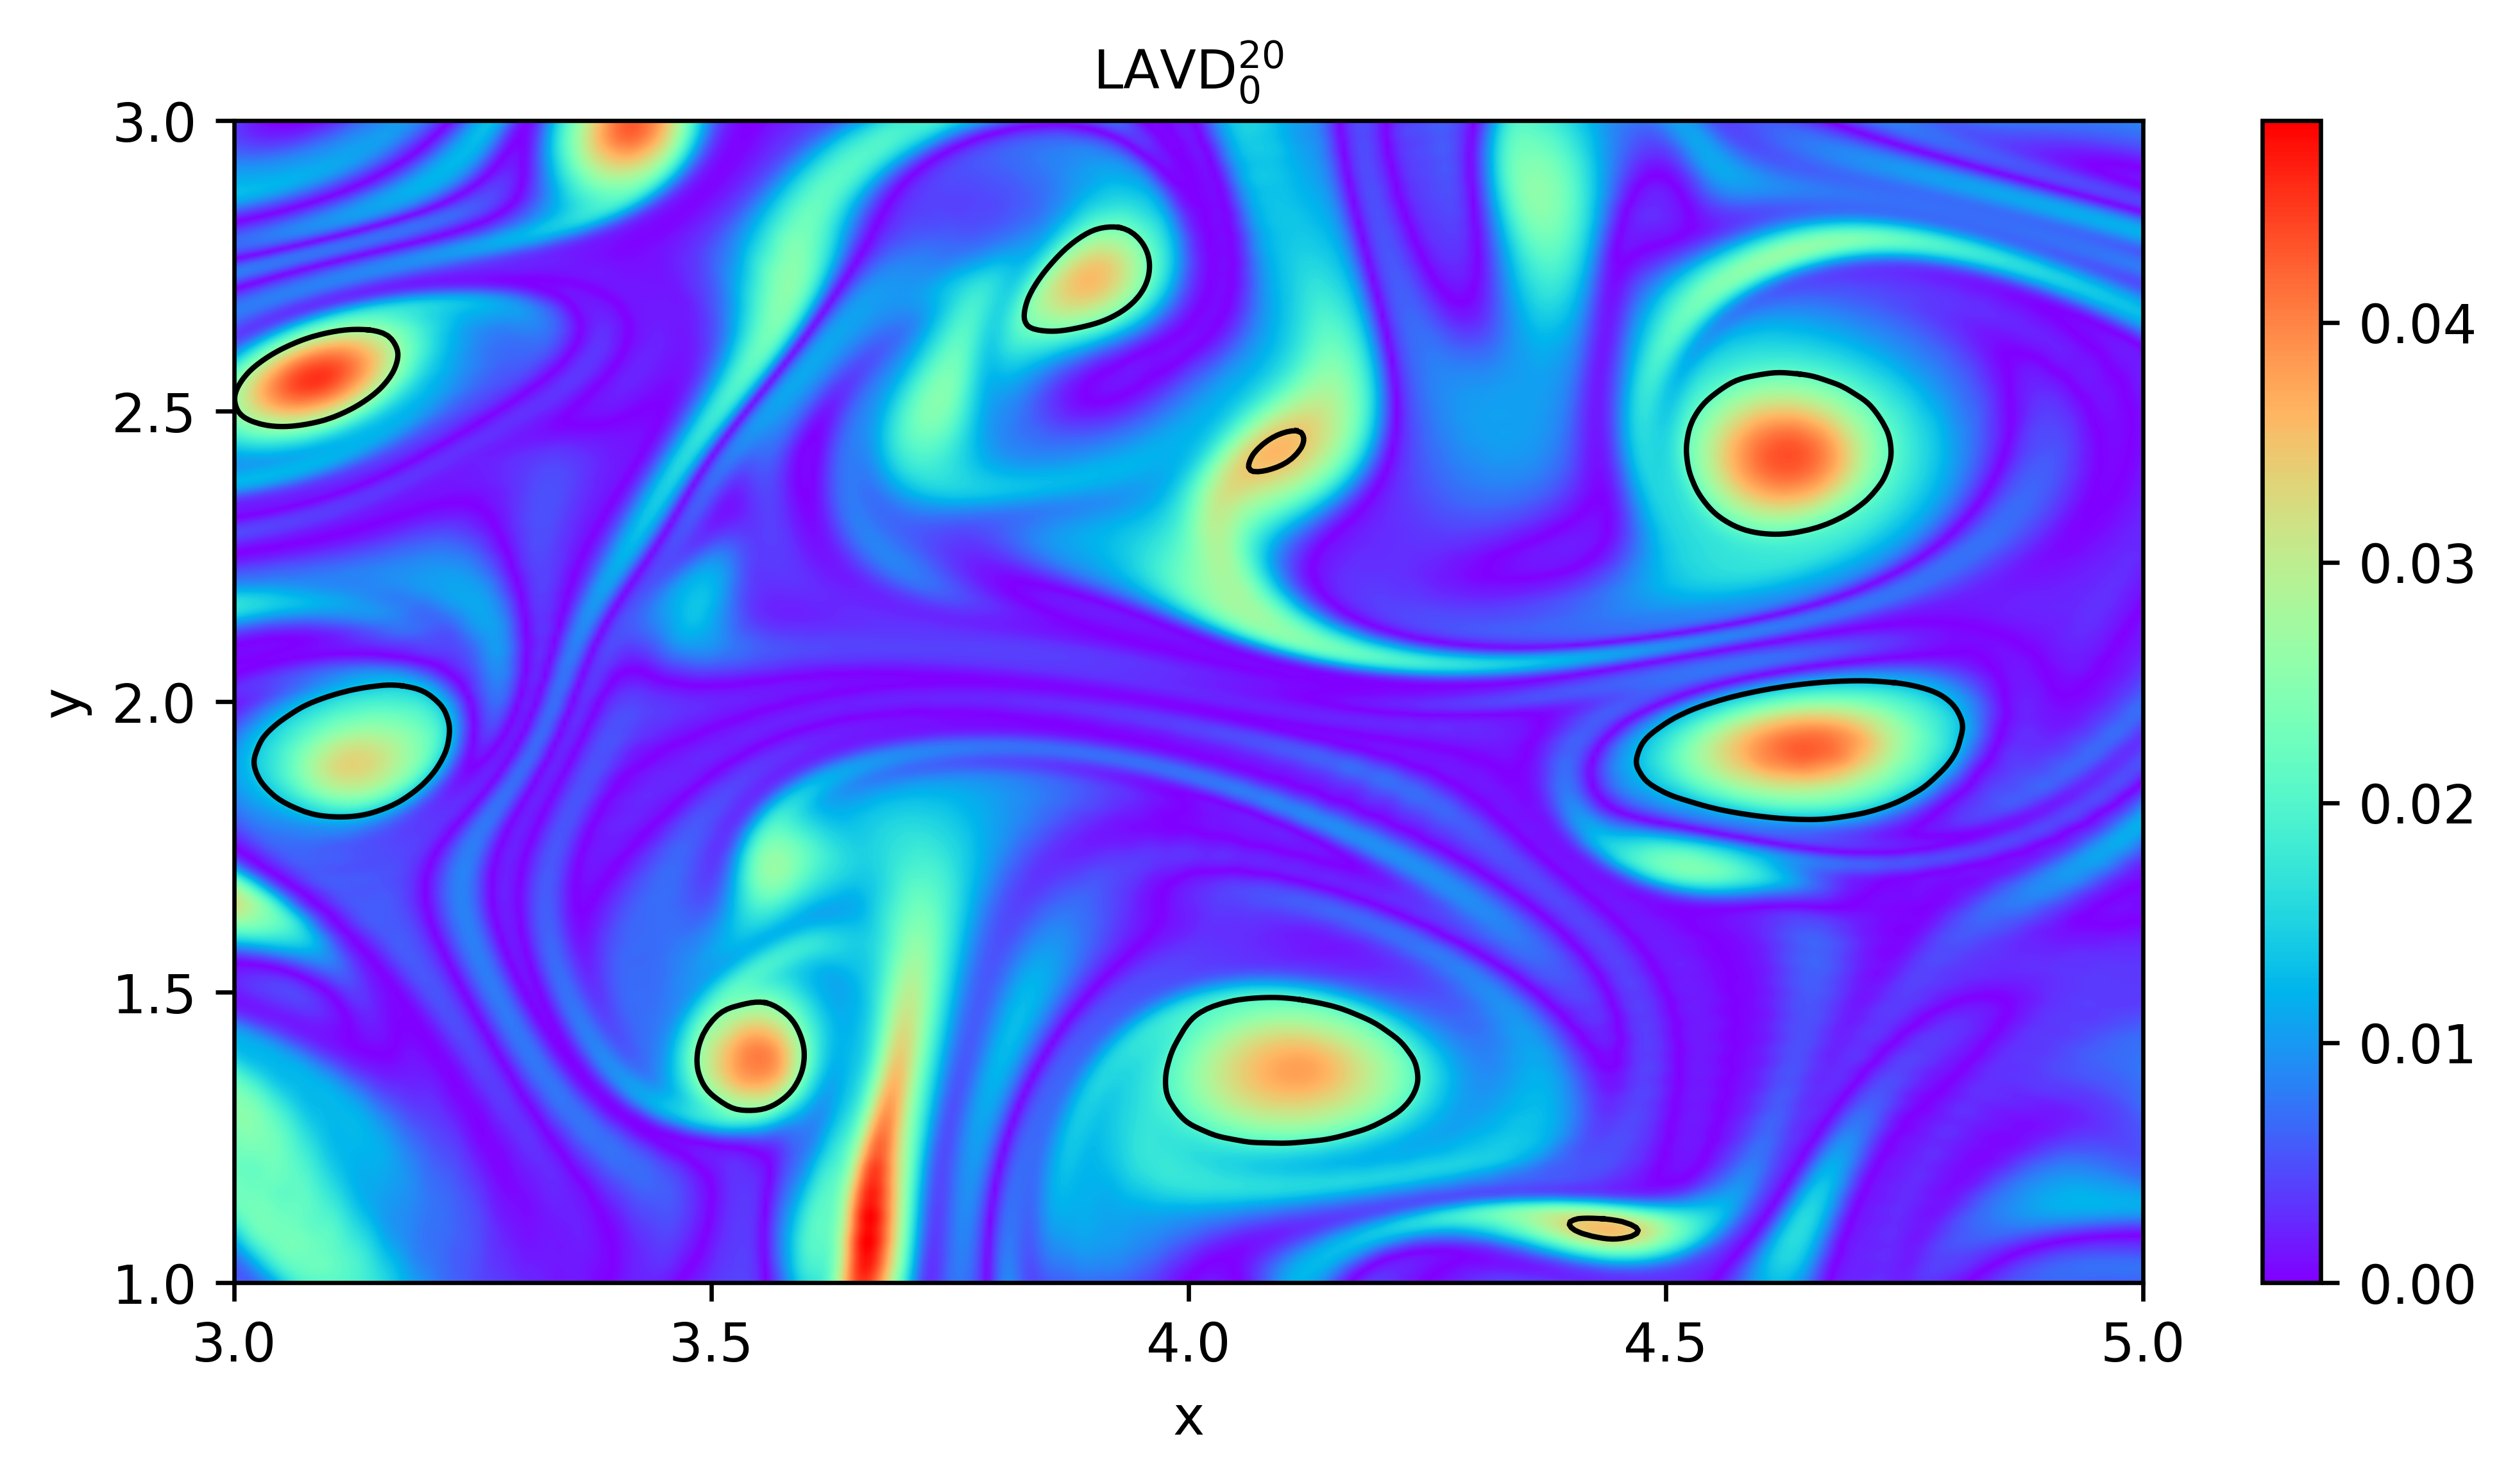

In [9]:
############################################ PLOT RESULTS ############################################
import matplotlib.pyplot as plt

# Figure/Axis
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# Contourplot of LAVD over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, LAVD, cmap = "rainbow", levels = 600)

# Axis Labels
ax.set_xlabel("x", fontsize = 10)
ax.set_ylabel("y", fontsize = 10)

# plot vortex boundaries
for v in vortex:
    ax.plot(v[0], v[1], c = "k", linestyle = "solid", linewidth = 1)

# Set axis ticks
ax.set_xticks(np.arange(xmin, xmax+0.1, .5))
ax.set_yticks(np.arange(ymin, ymax+0.1, .5))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.arange(0, .1, .01))

# Title
ax.set_title(r'$ \mathrm{LAVD}$'+f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$', fontsize = 10)

plt.show()

Vortical flow regions are identified as closed level curves around local extrema of the $ \mathrm{LAVD} $ satisfying specific conditions. The closed black lines indicate the identified vortex boundaries. The elliptic LCSs are clearly visible as concentric closed contours of the $ \mathrm{LAVD} $ at time $ t_0 $. These elliptic islands clearly distinguish vortical regions from the remaining flow. Note that the $ \mathrm{LAVD} $ highlights more vortical flow structures than other commonly and more reliably used rotation diagnostics such as the [EllipticLCS](../../EllipticLCS/Main/EllipticLCSTurbulence.ipynb) or the [PRA](../../PRA2D/Main/PRATurbulence.ipynb).

# References

[1] Haller, G., Hadjighasem, A., Farazmand, M., & Huhn, F. (2016). Defining coherent vortices objectively from the vorticity. Journal of Fluid Mechanics, 795, 136-173.

[2] Notebook 5.2.8. in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.